# Spherical harmonic spectrum diagrams, using HealPy

---------------

In [1]:
### Import Packages: so many, gathered here 

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## HEALPix Specific
import healpy as hp
import healpix
import easygems.healpix as egh

import cartopy.crs as ccrs
import cartopy.feature as cf

-------------
# Catalog of hackathon datasets 
--------------

In [4]:
import intake
# catalogue from which node? 
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["NCAR"]

-------------------
# Any old field from any dataset

In [15]:
ZOOMLEVEL=3  # mpas_dyamond goes up to 10 

ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()


/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<Figure size 640x480 with 0 Axes>

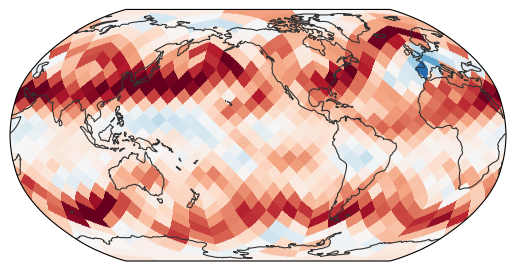

In [16]:
# Quick healpix plot of u in upper troposphere
egh.healpix_show(ds['uReconstructZonal'][1,:,30], vmin=-50, vmax=50, cmap='RdBu_r');  #, cbar=True);

In [17]:
# Try uxarray plot instead of easygems, it has a colorbar etc (bokeh) 

import uxarray as ux 
uxds = ux.UxDataset.from_healpix(ds)

In [18]:
# Uxarray uses bokeh not matplotlib, more services 
uxds.uReconstructZonal[1,:,30].plot(features=["coastline"])

:Overlay
   .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude uReconstructZonal)
   .Coastline.I :Feature   [Longitude,Latitude]

-----------------
# learn to use spherical harmonics in healpy
----------------

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<Figure size 640x480 with 0 Axes>

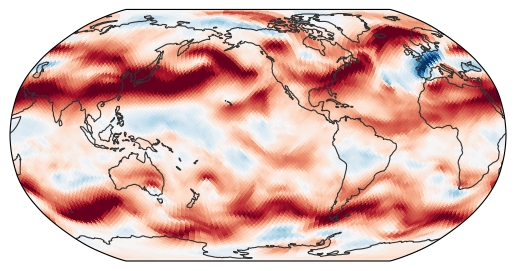

In [158]:
ZOOMLEVEL=5  # mpas_dyamond goes up to 10 

ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()
myfield = ds.uReconstructZonal[1,:,30]

egh.healpix_show(myfield, vmin=-0.05*1000,vmax=0.05*1000,cmap='RdBu_r');  #, cbar=True);

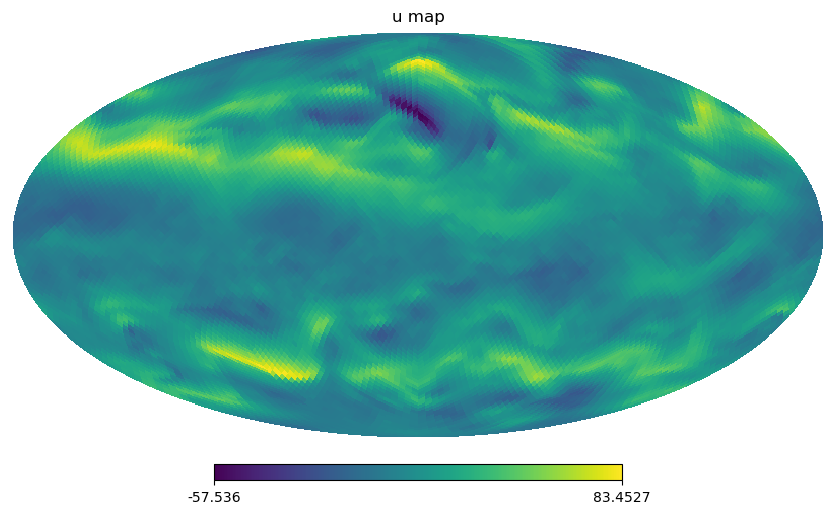

In [170]:
# 1. HealPy plot the data, nest format
hp.mollview(myfield.to_numpy(), nest=True, title="u map")

In [125]:
# def plot_alm_coefficients

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_alm_coefficients(healpix_map, lmax, mmax=None, zoomlabel=''):
    """
    Plots the absolute values of the spherical harmonic coefficients (alm)
    from a healpix map as a 2D pcolormesh, labeled with zonal and meridional
    wavenumbers.

    Parameters
    ----------
    healpix_map : array-like
        A HEALPix map.
    lmax : int
        Maximum degree l of the spherical harmonic coefficients.
    mmax : int, optional
        Maximum order m of the spherical harmonic coefficients.
        If None, defaults to lmax.
    """
    if mmax is None:
        mmax = lmax

    # Compute the spherical harmonic coefficients.
    alm = hp.map2alm(healpix_map, lmax=lmax, mmax=mmax)

    # Get the l and m values corresponding to the alm coefficients.
    l_values, m_values = hp.Alm.getlm(lmax)

    # Reshape the alm coefficients and l/m values for plotting.
    # The shape will be (lmax + 1, lmax + 1), even if mmax < lmax,
    # but the upper triangle will contain the relevant data.
    alm_matrix = np.zeros((lmax + 1, lmax + 1), dtype=np.complex128)
    abs_alm_matrix = np.zeros((lmax + 1, lmax + 1))
    l_matrix = np.zeros((lmax + 1, lmax + 1), dtype=int)
    m_matrix = np.zeros((lmax + 1, lmax + 1), dtype=int)

    alm_index = 0
    for l in range(lmax + 1):
        for m in range(l + 1):
            alm_matrix[l, m] = alm[alm_index]
            abs_alm_matrix[l, m] = np.abs(alm[alm_index])
            l_matrix[l, m] = l
            m_matrix[l, m] = m
            alm_index += 1

    # Create the plot.
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use pcolormesh to create the 2D plot.  We only plot the upper
    # triangle, which contains the unique information.
    im = ax.pcolormesh(
        np.arange(mmax + 2),  # x-coordinates for columns (m)
        np.arange(lmax + 2),  # y-coordinates for rows (l)
        abs_alm_matrix[:lmax+1, :mmax+1], # The data: abs(alm[l, m])
        cmap='viridis',  # Choose a colormap
        shading='auto'
    )

    # Add a colorbar.
    cbar = fig.colorbar(im, ax=ax, label='$|amplitude|$', extend='max')

    # Set the axis labels.
    ax.set_xlabel('Zonal Wavenumber (m)', fontsize=14)
    ax.set_ylabel('Meridional Wavenumber (l)', fontsize=14)
    ax.set_title('Absolute Values of Spherical Harmonic Coefficients, zoom '+zoomlabel, fontsize=14)

    # Set the tick locations and labels.  We add 0.5 to the locations TOO MANY TICKS 
    # so the labels are centered in the cells.
    #ax.set_xticks(np.arange(mmax + 1) + 0.5)
    #ax.set_xticklabels(np.arange(mmax + 1), fontsize=12)
    #ax.set_yticks(np.arange(lmax + 1) + 0.5)
    #ax.set_yticklabels(np.arange(lmax + 1), fontsize=12)

    # Make sure the plot limits are correct.
    ax.set_xlim(0, mmax + 1)
    ax.set_ylim(0, lmax + 1)
    ax.invert_yaxis()  # Put l=0 at the bottom, as is conventional

    # Add text labels for the l and m values in each cell.  This can
    # be helpful for interpreting the plot, but can make it cluttered
    # for very high lmax/mmax.
    if lmax <= 20: # Don't add labels if its too big
        for l in range(lmax + 1):
            for m in range(l + 1):
                text = ax.text(m + 0.5, l + 0.5, f'{l},{m}',
                               ha='center', va='center', color='white', fontsize=8)

    plt.tight_layout()
    plt.show()

In [126]:
# Spherical harmonic computation in l (meridional) and m (zonal) wavenumbers 

my_map = ds.w[1,:,50].to_numpy()
nside = hp.get_nside(my_map)
lmax = 3 * nside - 1
mmax = lmax

# Compute the spherical harmonic coefficients (alm)
alm = hp.map2alm(my_map, lmax=lmax, mmax=mmax)

<Figure size 800x800 with 0 Axes>

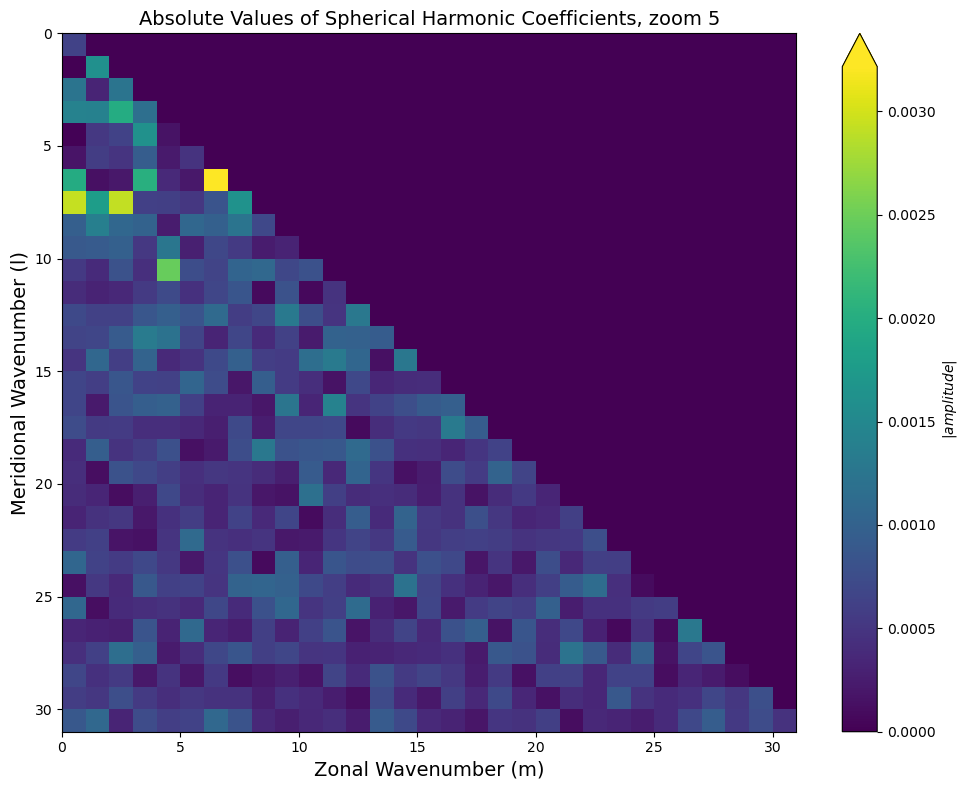

In [130]:
# 3. Call the plotting function.
plt.figure(figsize=(8,8))
plot_alm_coefficients(my_map, 30, zoomlabel=str(ZOOMLEVEL));

# Healpy spherical transform code (per Gemini)

In [194]:
# spherical spectrum plot 

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_alm(alm, lmax, title="Spherical Harmonic Coefficients"):

    l_vals, m_vals = hp.Alm.getlm(lmax)
    abs_alm = np.zeros((lmax + 1, lmax + 1))
    for i in range(alm.size):
        if m_vals[i] >= 0: # only plot for positive m
            abs_alm[l_vals[i], m_vals[i]] = np.abs(alm[i])

    plt.figure(figsize=(4, 3))
    plt.pcolormesh(np.log(abs_alm), cmap='viridis', shading='auto')
    plt.xlabel('Zonal Wavenumber (m)')
    plt.ylabel('Meridional Wavenumber (l)')
    plt.title(title)
    plt.colorbar(label='$log(amplitude)$', extend='max')
    plt.tight_layout()
    plt.show()

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/glade/derecho/scratch/mapes/tmp/ipykernel_121003/436748875.py:16: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(np.log(abs_alm), cmap='viridis', shading='auto')


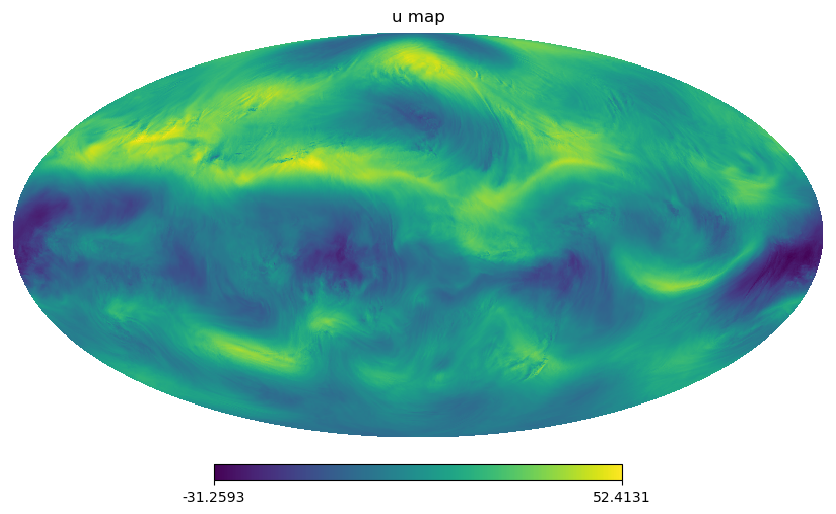

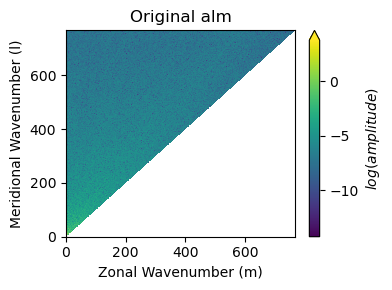

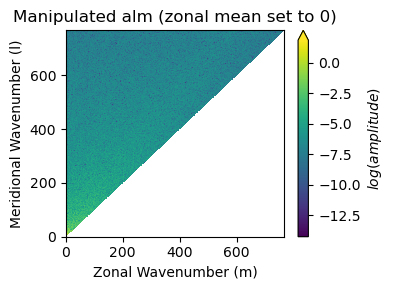

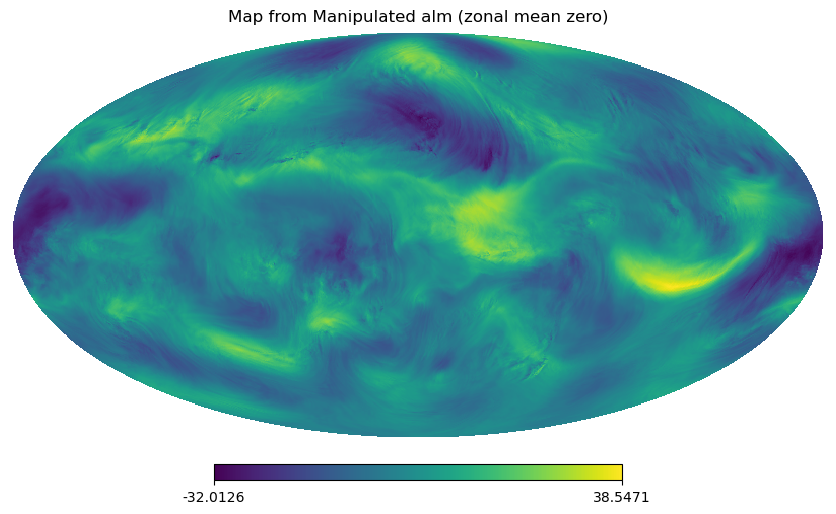

In [195]:
# Okay, let's remove the zonal mean as a test 

ZOOMLEVEL=8  # mpas_dyamond goes up to 10 

ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()
my_map = ds.uReconstructZonal[1,:,40].to_numpy()
hp.mollview(my_map, nest=True, title="u map")

# 2. Compute the spherical harmonic coefficients.

# Convert to ring order 
map_data_ring = hp.reorder(my_map, n2r=True)      # to Ring ordering 
nside = hp.get_nside(map_data_ring)
lmax = 3 * nside - 1; mmax = lmax
alm = hp.map2alm(map_data_ring, lmax=lmax)

# 3. Plot the original alm
plot_alm(alm, lmax, title="Original alm")

# 4. Manipulate the alm coefficients (example: set m=0 to zero).
l_vals, m_vals = hp.Alm.getlm(lmax)
manipulated_alm = alm.copy() # Create a copy to avoid modifying the original
manipulated_alm[m_vals == 0] = 0
plot_alm(manipulated_alm, lmax, title="Manipulated alm (zonal mean set to 0)")

# 5. Visualize the resulting map from manipulated alm 
hp.mollview(hp.alm2map(manipulated_alm, nside, lmax=lmax), title="Map from Manipulated alm (zonal mean zero)")